In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import datetime

In [15]:
df = pd.read_excel('Book4.xlsx')  # Replace 'your_file.csv' with the actual file path

# Convert 'Date' column to datetime format using the specified format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# Combine 'Date' and 'TIMESLOT' into a single datetime column using pd.Timestamp.combine
df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'].date(), row['TIMESLOT']), axis=1)

# Drop the original 'Date' and 'TIMESLOT' columns
df.drop(columns=['Date', 'TIMESLOT'], inplace=True)

# Set the new Datetime column as the index
df.set_index('Datetime', inplace=True)

# Resample to 5-minute intervals (should align naturally since it's already in 5-minute steps)
df = df.asfreq('5min')

# Interpolate missing values (if necessary)
df.interpolate(method='time', inplace=True)

# Display the first few rows to verify the result
print(df.head())


                       DELHI    BRPL    BYPL    NDPL    NDMC    MES
Datetime                                                           
2021-01-01 00:00:00  2318.54  973.49  452.98  711.43  129.75  28.74
2021-01-01 00:05:00  2238.05  933.48  420.41  702.30  131.75  28.40
2021-01-01 00:10:00  2192.71  925.58  404.30  680.26  134.17  27.69
2021-01-01 00:15:00  2158.28  908.45  404.75  662.20  133.95  27.36
2021-01-01 00:20:00  2046.05  793.02  409.20  664.50  131.94  27.41


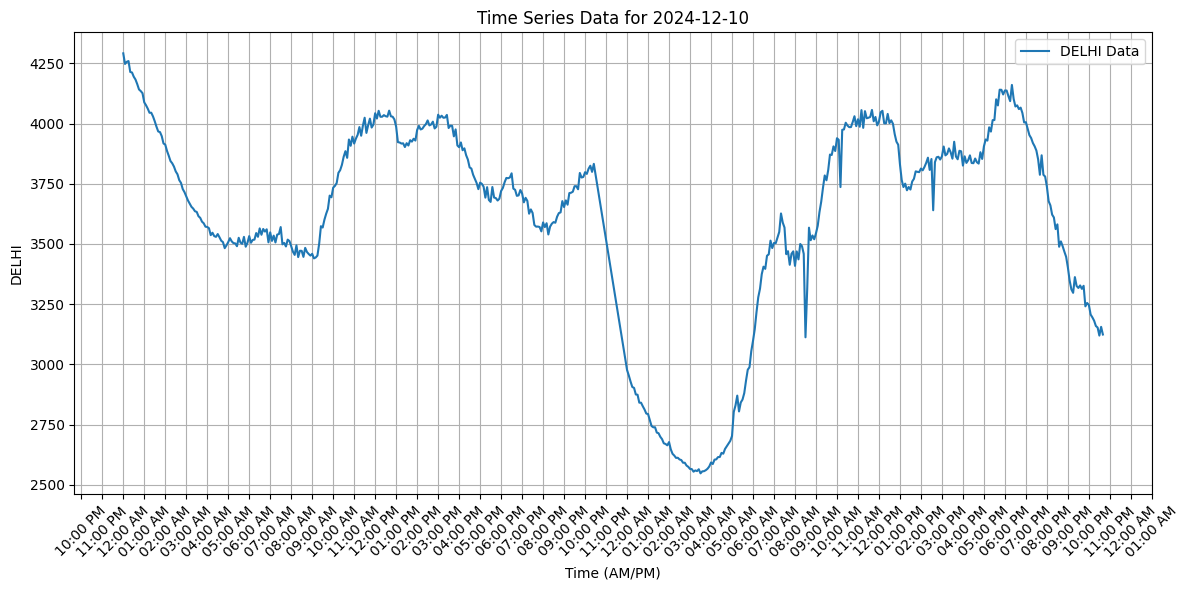

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure your datetime index is in the correct datetime format
start_date = '2024-12-10'
end_date = '2024-12-11'

# Filter the data for 10th December 2024
filtered_df = df.loc[start_date:end_date]

# Replace 'DELHI' with the actual column you want to plot
column_to_plot = 'DELHI'  # Change to your desired column name

# Check if the filtered DataFrame is not empty
if not filtered_df.empty:
    # Plot the filtered data
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df.index, filtered_df[column_to_plot], label=f"{column_to_plot} Data")

    # Format the x-axis to show time in AM/PM format without the date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set 24 intervals, one for each hour

    plt.title(f"Time Series Data for {start_date}")
    plt.xlabel("Time (AM/PM)")
    plt.ylabel(column_to_plot)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for {start_date}. Please check your DataFrame.")


In [10]:
# Step 4: Stationarity Check (Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['DELHI'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")



ADF Statistic: -23.047657363554325
p-value: 0.0
Data is stationary


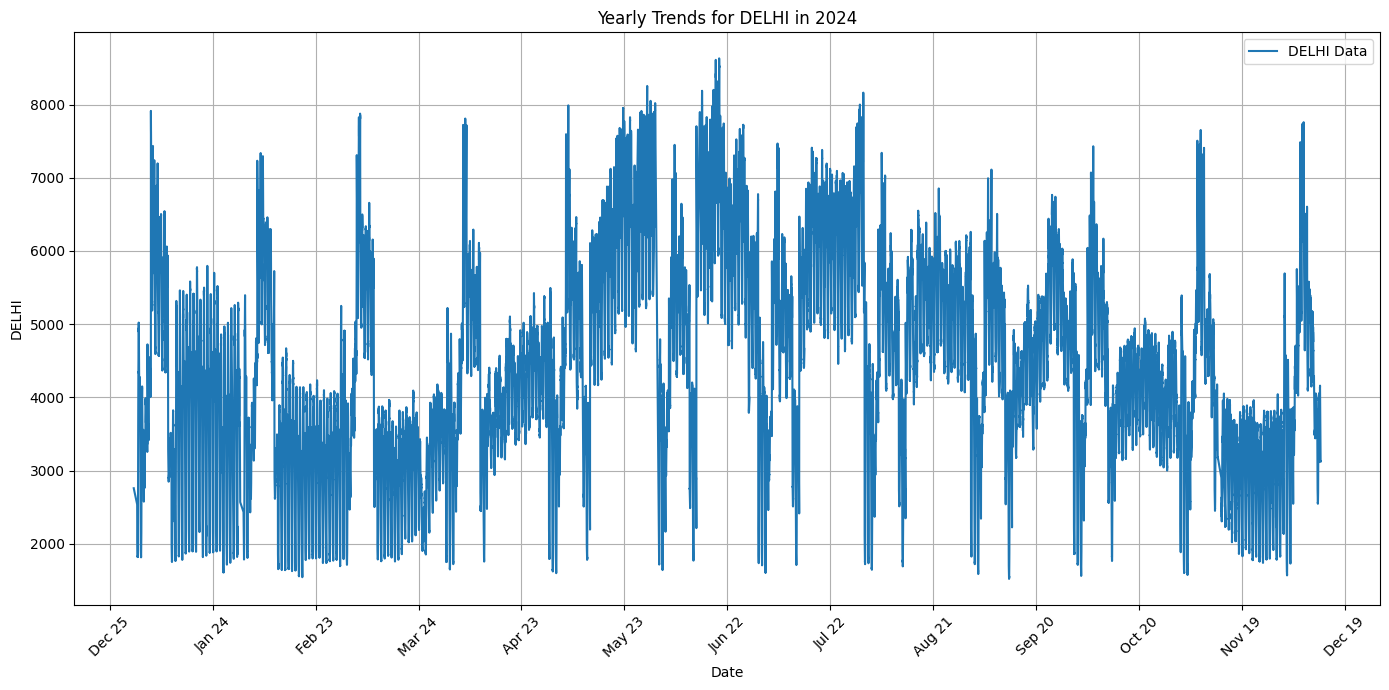

In [34]:


import matplotlib.dates as mdates

# Define the start and end dates for the year
start_date = '2024-01-01'
end_date = '2024-12-31'

# Filter the data for the entire year of 2024
filtered_df = df.loc[start_date:end_date]

# Replace 'DELHI' with the actual column you want to plot
column_to_plot = 'DELHI'  # Change to your desired column name

# Check if the filtered DataFrame is not empty
if not filtered_df.empty:
    # Plot the filtered data
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_df.index, filtered_df[column_to_plot], label=f"{column_to_plot} Data")

    # Format the x-axis for yearly trends with 30-day intervals
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Show month and day (e.g., Jan 01)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))   # Set divisions every 30 days

    plt.title(f"Yearly Trends for {column_to_plot} in 2024")
    plt.xlabel("Date")
    plt.ylabel(column_to_plot)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the year 2024. Please check your DataFrame.")


In [11]:
def fit_and_forecast_sarima(train_series, test_series, order=(2,0,2), seasonal_order=(1,0,1,288)):
    """
    Fit SARIMA on the training series and forecast over the test_series period.
    Parameters:
        order: (p,d,q) for non-seasonal
        seasonal_order: (P,D,Q,m) for seasonal components, where m=288 for daily cycle (5-min intervals).
    Note: Adjust these parameters based on model selection or auto_arima.
    """
    model = SARIMAX(train_series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast the length of the test period
    forecast_steps = len(test_series)
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast.index = test_series.index  # Align forecast index with test_series
    return forecast


In [13]:
columns_to_model = ['DELHI', 'BRPL', 'BYPL', 'NDPL', 'NDMC', 'MES']

In [14]:
results = {}

In [3]:
    for col in columns_to_model:
    train_series = train_df[col].dropna()
    test_series = test_df[col].dropna()

    if train_series.empty or test_series.empty:
        print(f"Skipping {col} due to lack of data in train or test.")
        continue

    # Fit and forecast SARIMA model
    # Adjust orders after exploration (p,d,q,P,D,Q,m)
    forecast = fit_and_forecast_sarima(train_series, test_series, order=(2,0,2), seasonal_order=(1,0,1,288))

    # Store results
    results[col] = {
        'actual': test_series,
        'forecast': forecast
    }

IndentationError: expected an indented block after 'for' statement on line 1 (739283816.py, line 2)

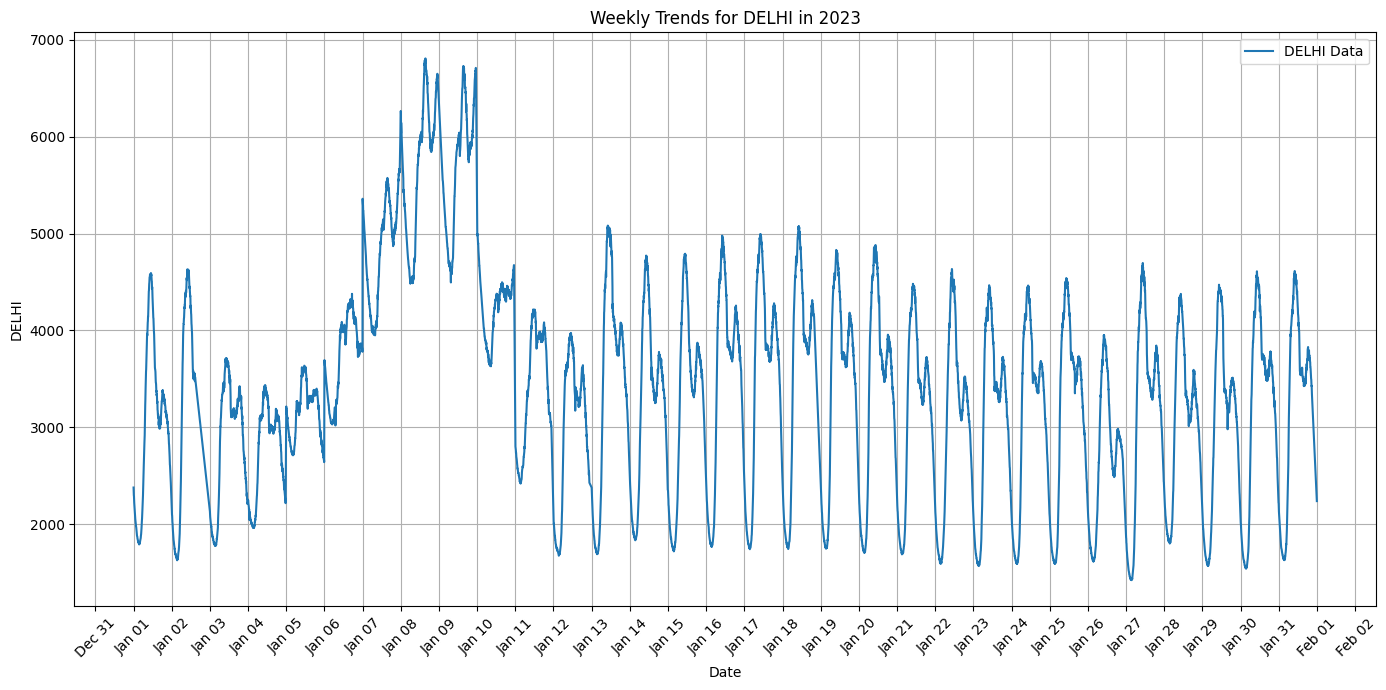

C:\Users\Sanchit\AppData\Local\Temp\ipykernel_10628\3415089806.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


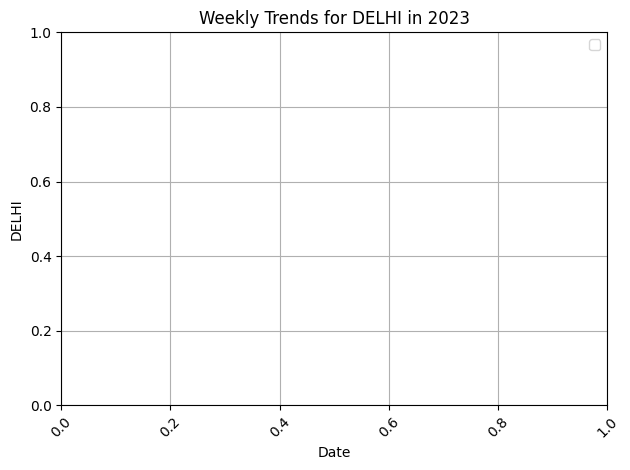

In [24]:


import matplotlib.dates as mdates

# Define the start and end dates for the year
start_date = '2023-01-01'
end_date = '2023-01-31'

# Filter the data for the entire year of 2024
filtered_df = df.loc[start_date:end_date]

# Replace 'DELHI' with the actual column you want to plot
column_to_plot = 'DELHI'  # Change to your desired column name

# Check if the filtered DataFrame is not empty
if not filtered_df.empty:
    # Plot the filtered data
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_df.index, filtered_df[column_to_plot], label=f"{column_to_plot} Data")

    # Format the x-axis for yearly trends with 30-day intervals
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Show month and day (e.g., Jan 01)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set divisions every 30 days

    plt.title(f"Weekly Trends for {column_to_plot} in 2023")
    plt.xlabel("Date")
    plt.ylabel(column_to_plot)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()
    plt.title(f"Weekly Trends for {column_to_plot} in 2023")
    plt.xlabel("Date")
    plt.ylabel(column_to_plot)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()